# Exploratory Analysis on Bike Robbery at São Paulo, Brazil

*Danilo Lessa Bernardineli (danilo.lessa@gmail.com)*

## Intro

Through the help of SIC/SP (Serviço de Informação ao Cidadão), we have access to an dataset with all police reports regarding bike robbery. The temporal range is from Jan/2002 to Jul/2022 (inclusive).

This notebook is an first stab in extracting insights from that dataset.

## Setting up the essentials

In [1]:
# Dependences
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import plotly.io as pio


# Settings
pio.renderers.default = "png" # Uncomment for plots to be visible on Github

In [2]:
# Load Data
dataset_path = '../data/dataset.csv.zip'

rename_dict = {'CIDADE': 'city'}
def convert_occurence_time(s):
    if type(s) == str:
        lst = s.split(":")
        if len(lst) == 2:
            return int(lst[0]) + int(lst[1]) / 60
        else:
            return None
    else:
        return None


df = (pd.read_csv(dataset_path)
        .assign(registry_timestamp=lambda df: pd.to_datetime(df.DATAHORA_REGISTRO_BO))
        .rename(columns=rename_dict)
        .assign(occurence_hour=lambda df: df.HORA_OCORRENCIA_BO.map(convert_occurence_time))
     )

## Analysis

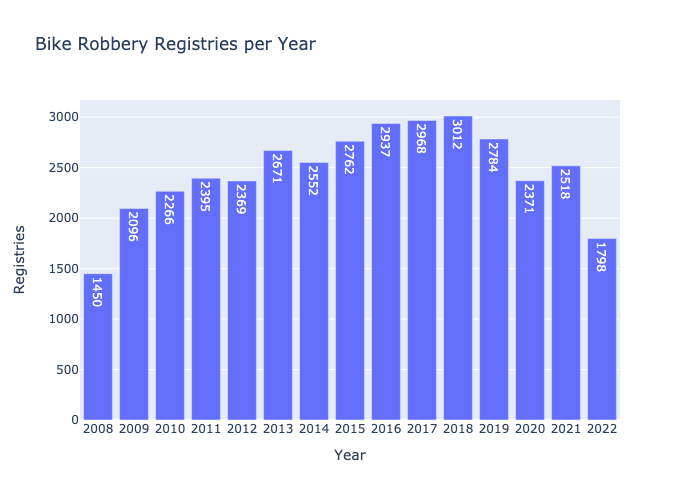

In [3]:
def plot_robberies_per_year(df, title='Bike Robbery Registries per Year'):
    fig_df = df.groupby([df.registry_timestamp.dt.year]).count().ID_DELEGACIA
    fig_df.name = 'count'
    fig_df = fig_df.reset_index().query('registry_timestamp > 2007')

    fig = px.bar(fig_df,
                 x='registry_timestamp',
                 y='count',
                 title=title,
                 text='count',
                 labels={'count': 'Registries',
                         'registry_timestamp': 'Year'})
    fig.update_layout(
        xaxis = dict(
            tickmode = 'linear',
            dtick = 1
        )
    )
    fig.show()


plot_robberies_per_year(df)


In [4]:
N_head = 7
BOTTOM_CITIES_PLACERHOLDER = 'Other'


def retrieve_bottom_top_registries_per_city(df, N_head=N_head):
    registries_per_city = df.city.value_counts().sort_values(ascending=False)

    registries_per_bottom_cities = registries_per_city[N_head:]
    registries_per_top_cities = registries_per_city[0:N_head]
    return registries_per_bottom_cities,registries_per_top_cities
    
def retrieve_clean_registries_per_city(df,
                                       N_head=N_head,
                                       placeholder=BOTTOM_CITIES_PLACERHOLDER):
    registries_per_bottom_cities, registries_per_top_cities = retrieve_bottom_top_registries_per_city(df, N_head)

    clean_registries_per_cities = registries_per_top_cities
    clean_registries_per_cities[placeholder] = registries_per_bottom_cities.sum(
    )
    return clean_registries_per_cities



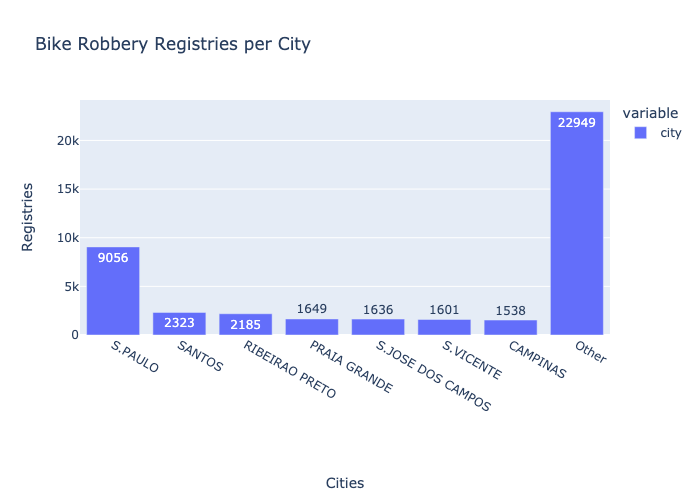

In [5]:
def plot_robberies_per_city(df, *args, **kwargs):
    clean_registries_per_cities = retrieve_clean_registries_per_city(df, *args, **kwargs)
    fig = px.bar(clean_registries_per_cities,
             title='Bike Robbery Registries per City',
             text='value',
             labels={'value': 'Registries',
                     'index': 'Cities'})
    fig.show()

plot_robberies_per_city(df)

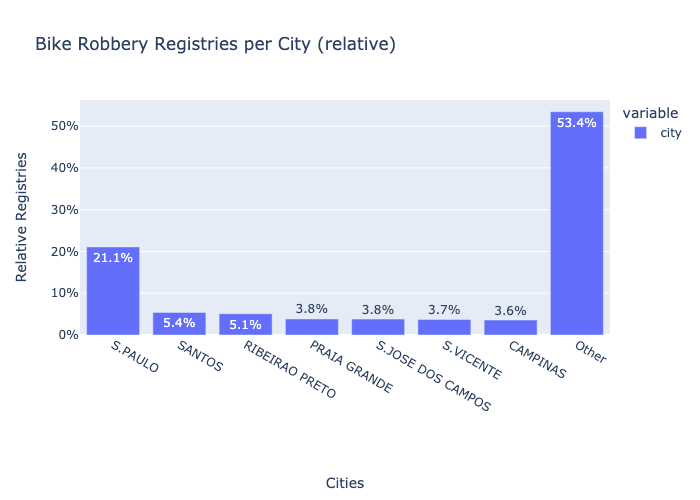

In [6]:
def plot_relative_robberies_per_city(df, *args, **kwargs):
        clean_registries_per_cities = retrieve_clean_registries_per_city(df, *args, **kwargs)
        fig = px.bar(clean_registries_per_cities / clean_registries_per_cities.sum(),
                title='Bike Robbery Registries per City (relative)',
                text='value',
                text_auto='.1%',
                labels={'value': 'Relative Registries',
                        'index': 'Cities'})

        fig.layout.yaxis.tickformat = ',.0%'
        fig.show()

plot_relative_robberies_per_city(df)

In [7]:
def get_top_cities_registries(df, *args, **kwargs):
    _, registries_per_top_cities = retrieve_bottom_top_registries_per_city(df, *args, **kwargs)

    top_cities = set(registries_per_top_cities.index)

    top_cities_df = (df.assign(city=lambda df: df.city.map(lambda x: x if x in top_cities else BOTTOM_CITIES_PLACERHOLDER))
                    )
                    
    return top_cities_df

def get_registries_per_top_city_year(df):
    top_cities_df = get_top_cities_registries(df)

    registries_per_city_year = (top_cities_df.groupby(['city',
                                                    df.registry_timestamp.dt.year])
                                .count()
                                .registry_timestamp)
    registries_per_city_year.name = 'count'
    return registries_per_city_year

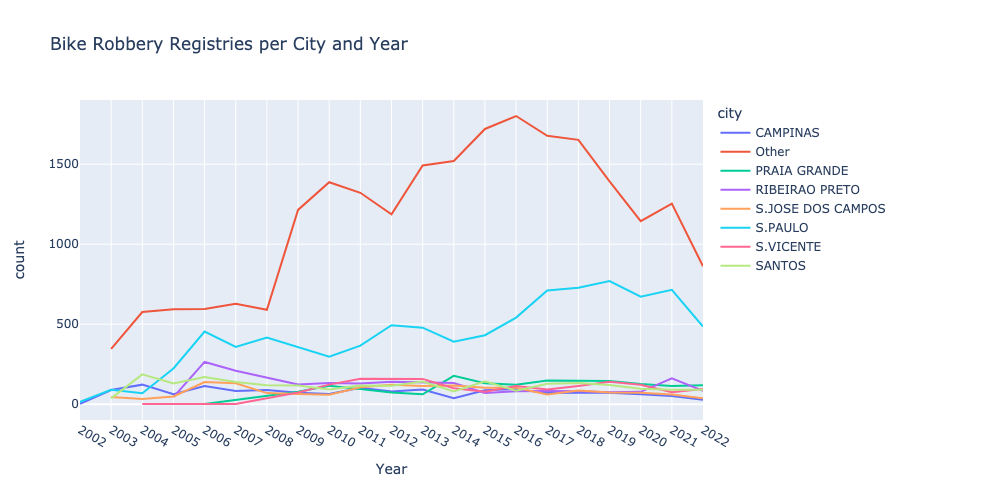

In [8]:
def plot_registries_per_city_year(df):
    registries_per_city_year = get_registries_per_top_city_year(df)
    fig_df = registries_per_city_year.reset_index()
    fig = px.line(fig_df,
                x='registry_timestamp',
                y='count',
                color='city',
                width=1000,
                title='Bike Robbery Registries per City and Year',
                labels={'value': 'Registries',
                        'registry_timestamp': 'Year'})

    fig.update_layout(
        xaxis = dict(
            tickmode = 'linear',
            dtick = 1
        )
    )
    fig.show()
plot_registries_per_city_year(df)

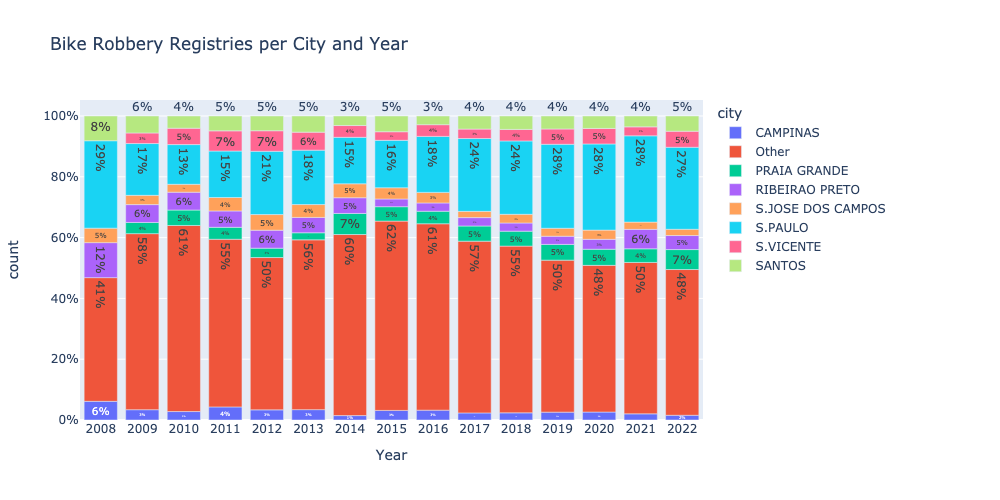

In [9]:
def plot_registries_per_city_year_relative(df, *args, **kwargs):
    registries_per_city_year = get_registries_per_top_city_year(df, *args, **kwargs)
    fig_df = (registries_per_city_year / registries_per_city_year.groupby('registry_timestamp').sum()).reset_index()
    fig = px.bar(fig_df.query('registry_timestamp > 2007'),
                x='registry_timestamp',
                y='count',
                color='city',
                width=1000,
                text='count',
                text_auto='.0%',
                title='Bike Robbery Registries per City and Year',
                labels={'value': 'Relative Registries',
                        'registry_timestamp': 'Year'})

    fig.update_layout(
        xaxis = dict(
            tickmode = 'linear',
            dtick = 1
        )
    )
    fig.layout.yaxis.tickformat = ',.0%'
    fig.show()
plot_registries_per_city_year_relative(df)

#### Temporal Patterns

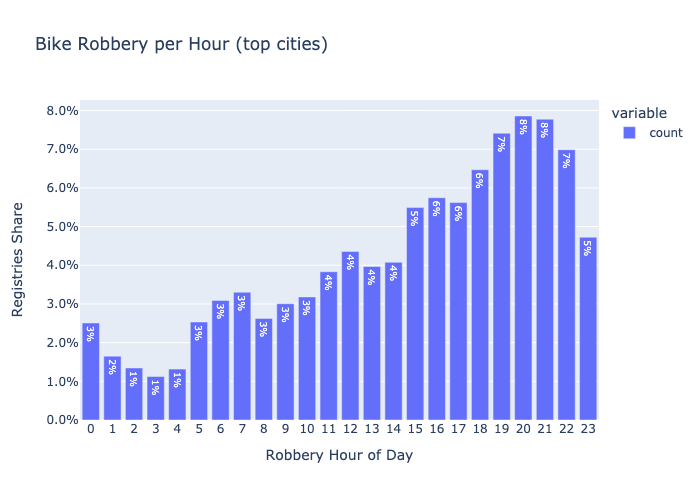

In [10]:
def plot_robbery_per_hour(df, *args, **kwargs):
    registries_per_hour = (df.groupby([df.occurence_hour.map(np.floor)])
                                .count()
                                .registry_timestamp)

    registries_per_hour.name = 'count'
    fig = px.bar(registries_per_hour / registries_per_hour.sum(),
                title='Bike Robbery per Hour (top cities)',
                text='value',
                text_auto='.0%',
                labels={'value': 'Registries Share',
                        'occurence_hour': 'Robbery Hour of Day'})
    fig.update_layout(
        xaxis = dict(
            tickmode = 'linear',
            dtick = 1
        )
    )
    fig.layout.yaxis.tickformat = ',.1%'
    fig.show()
plot_robbery_per_hour(df)

In [11]:
def get_registries_per_year_hour(df, *args, **kwargs):
    registries_per_year_hour = (df.groupby([df.registry_timestamp.dt.year,
                                                   df.occurence_hour.map(np.floor)])
                            .count()
                            .registry_timestamp)

    registries_per_year_hour.name = 'count'
    return registries_per_year_hour

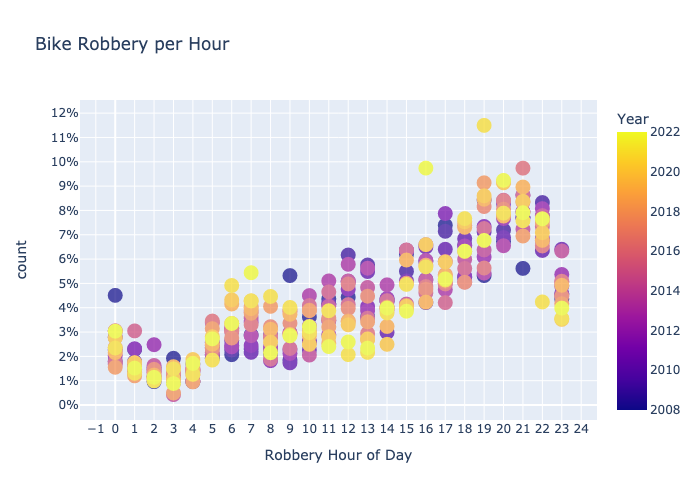

In [12]:

def plot_robbery_per_hour_scatter(df):
    registries_per_year_hour = get_registries_per_year_hour(df)

    fig_df = registries_per_year_hour / registries_per_year_hour.groupby('registry_timestamp').sum()
    fig_df = fig_df.reset_index()
    fig_df['registry_timestamp'] = fig_df['registry_timestamp'].astype(float)
    fig_df = fig_df.query('registry_timestamp > 2007')

    fig = px.scatter(fig_df,
                color='registry_timestamp',
                    x='occurence_hour',
                    y='count',
                title='Bike Robbery per Hour',
                labels={'registry_timestamp': 'Year',
                        'occurence_hour': 'Robbery Hour of Day'})
    fig.update_layout(
        xaxis = dict(
            tickmode = 'linear',
            dtick = 1
        ),
            yaxis = dict(
            tickmode = 'linear',
            dtick = 0.01
        )
    )
    fig.update_traces(marker_size=15)
    fig.update_traces(opacity=0.7)
    fig.layout.yaxis.tickformat = ',.0%'
    fig.show()
plot_robbery_per_hour_scatter(df)

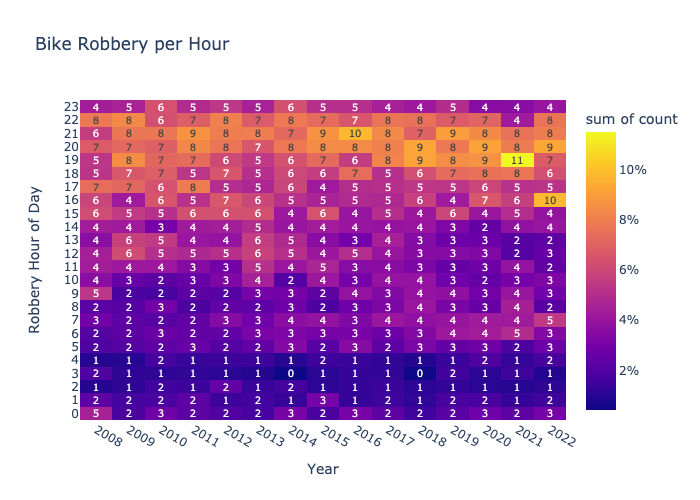

In [13]:
def plot_robbery_per_hour_heatmap(df):
    registries_per_year_hour = get_registries_per_year_hour(df)
    fig_df = registries_per_year_hour / registries_per_year_hour.groupby('registry_timestamp').sum() * 100
    fig_df = fig_df.reset_index().query('registry_timestamp > 2007')

    fig = px.density_heatmap(fig_df,
                x='registry_timestamp',
                    y='occurence_hour',
                    z='count',
                    nbinsx=25,
                    nbinsy=24,
                             text_auto='.0f',
                # y='count',
                # color='occurence_hour',
                title='Bike Robbery per Hour',
                labels={'registry_timestamp': 'Year',
                        'occurence_hour': 'Robbery Hour of Day'})
    fig.update_layout(
        xaxis = dict(
            tickmode = 'linear',
            dtick = 1
        ),
            yaxis = dict(
            tickmode = 'linear',
            dtick = 1
        )
    )
    fig.layout.coloraxis.colorbar['ticksuffix'] = '%'
    fig.show()
plot_robbery_per_hour_heatmap(df)

### Robbery per address type

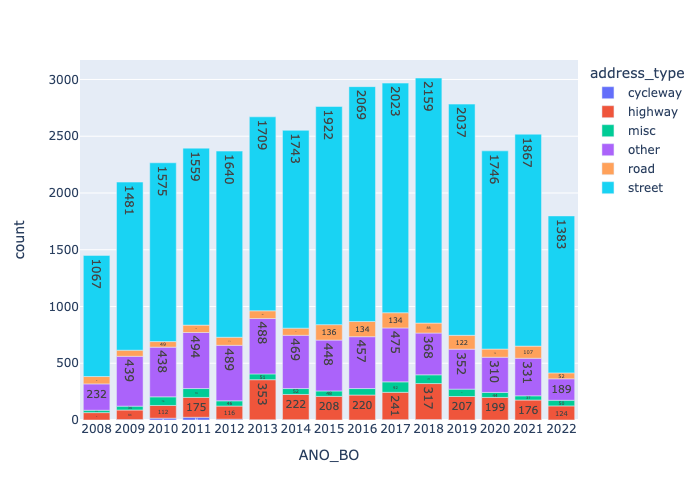

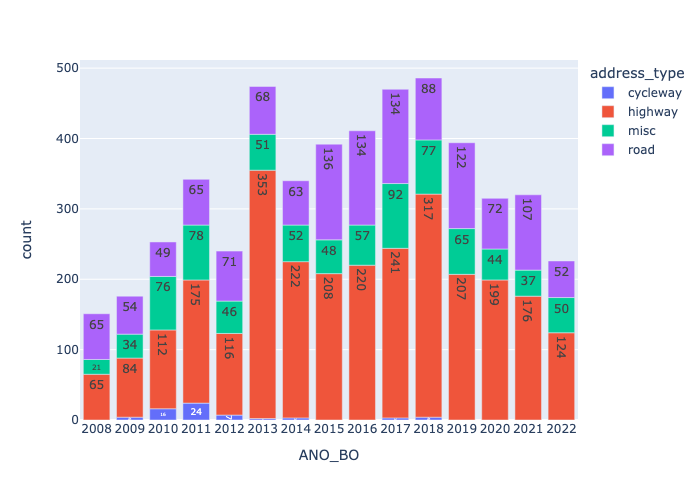

In [14]:
type_map = {
    'cycleway': ['CICLO'],
    'road': ['ESTRADA', 'EST '],
    'highway': ['RODOVIA', 'ROD. ', 'VIA ', 'RODOANEL', 'ROD ', 'MARGINAL ', 'ANEL VIARIO'],
    'street': ['RUA', 'AVENIDA', 'AV ', 'R ', 'AV.', 'TRAVESSA', 'R.', 'VIELA', 'VICINAL', 'ALAMEDA'],
    'misc': ['PONTE ', 'TUNEL ', 'LINHA ', 'PRAÇA ', 'PC ', 'VIADUTO']
}

def f(input):
    if type(input) == str:
        for highway, patterns in type_map.items():
            for pattern in patterns:
                if pattern in input:
                    return highway
        return 'other'
    else:
        return 'other'
    
df['address_type'] = df.LOGRADOURO.str.upper().map(f)



s = df.groupby(['address_type', 'ANO_BO']).address_type.count()
s.name = 'count'


fig_df = s.reset_index().query('ANO_BO > 2007')
fig = px.bar(fig_df,
              x='ANO_BO',
              y='count',
              text='count',
              color='address_type')
fig.update_layout(
    xaxis = dict(
        tickmode = 'linear',
        dtick = 1
    )
)
fig.show()

fig = px.bar(fig_df[(fig_df.address_type != 'street') & (fig_df.address_type != 'other')],
              x='ANO_BO',
              y='count',
              text='count',
              color='address_type')
fig.update_layout(
    xaxis = dict(
        tickmode = 'linear',
        dtick = 1
    )
)
fig.show()

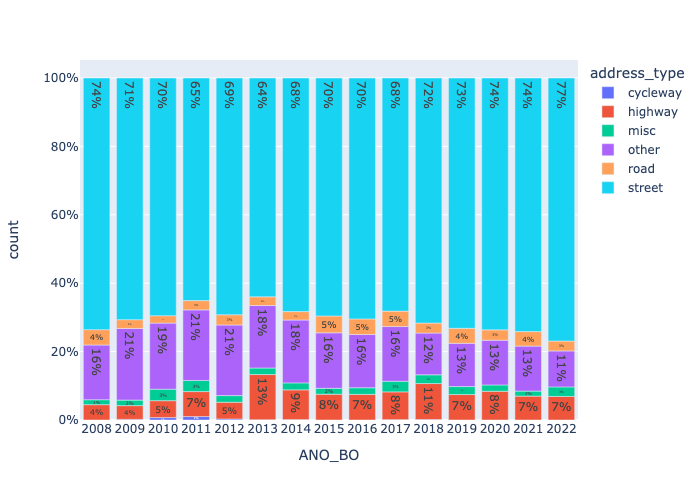

In [15]:
fig_df = (s / s.groupby('ANO_BO').sum()).reset_index().query('ANO_BO > 2007')
fig = px.bar(fig_df,
              x='ANO_BO',
              y='count',
              text='count',
              text_auto='.0%',
              color='address_type')
fig.update_layout(
    xaxis = dict(
        tickmode = 'linear',
        dtick = 1
    )
)
fig.layout.yaxis.tickformat = ',.0%'
fig.show()

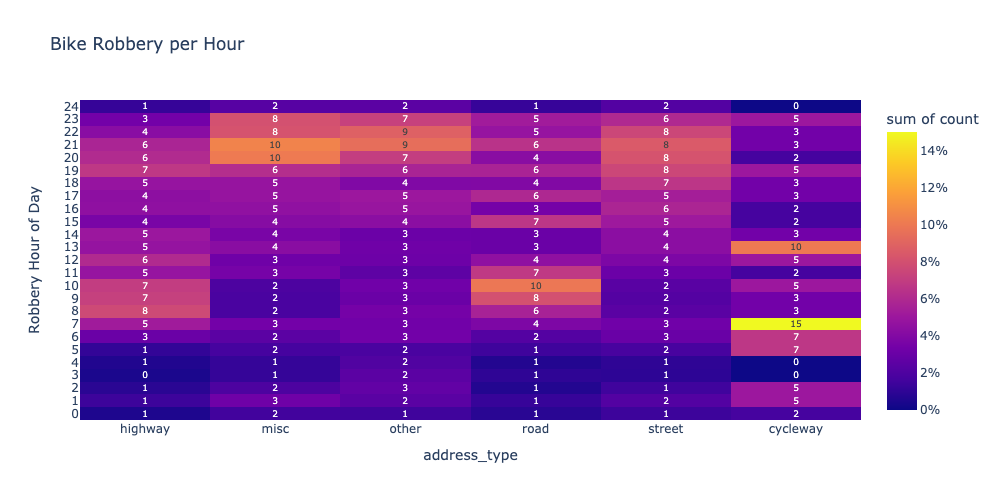

In [16]:
s = df.query('registry_timestamp > 2007').groupby(['occurence_hour', 'address_type']).address_type.count()
s.name = 'count'

fig_df = (s / s.groupby('address_type').sum()) * 100
fig_df = fig_df.reset_index()

fig = px.density_heatmap(fig_df,
            x='address_type',
                y='occurence_hour',
                z='count',
                nbinsx=25,
                nbinsy=24,
            text_auto='.0f',
            title='Bike Robbery per Hour',
            labels={'registry_timestamp': 'Year',
                    'occurence_hour': 'Robbery Hour of Day'},
                        width=1000)
fig.update_layout(
    xaxis = dict(
        tickmode = 'linear',
        dtick = 1
    ),
        yaxis = dict(
        tickmode = 'linear',
        dtick = 1
    )
)
fig.layout.coloraxis.colorbar['ticksuffix'] = '%'
fig.show()

### Robbery on Highways

In [17]:
ind = df.LOGRADOURO.str.contains('RODOVIA')
#ind &= df.LOGRADOURO.str.contains('BANDEIRANTES')
ind &= df.DESCR_CONDUTA == 'TRANSEUNTE'
ind = ~pd.isnull(ind) & (ind == True)
df2 = df.loc[ind]

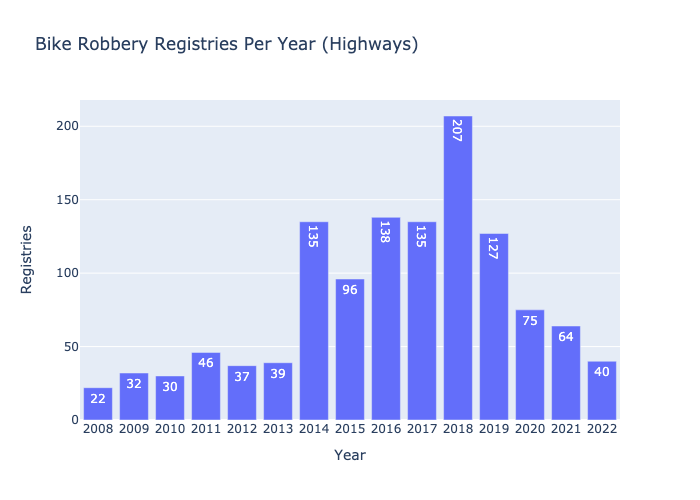

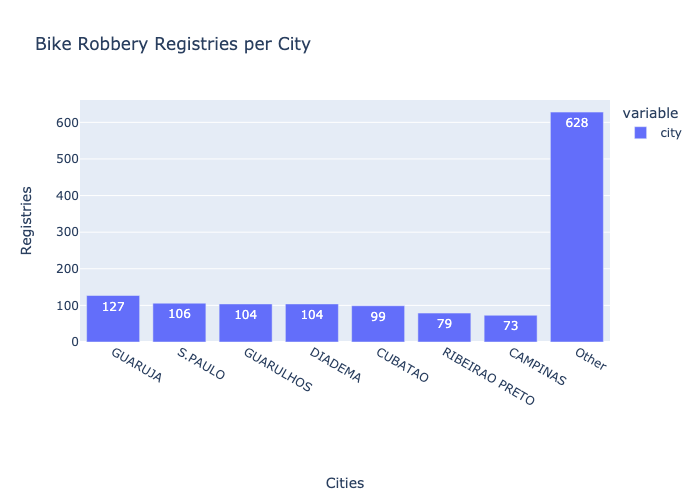

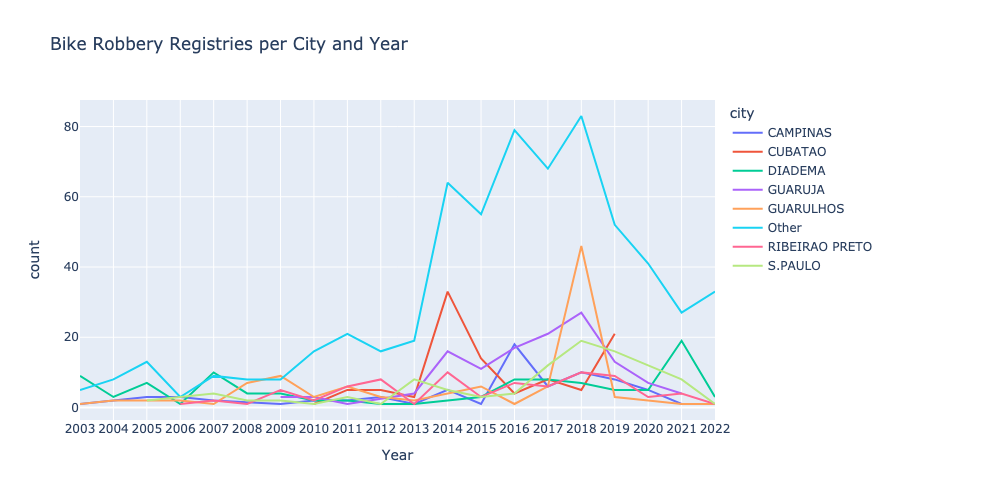

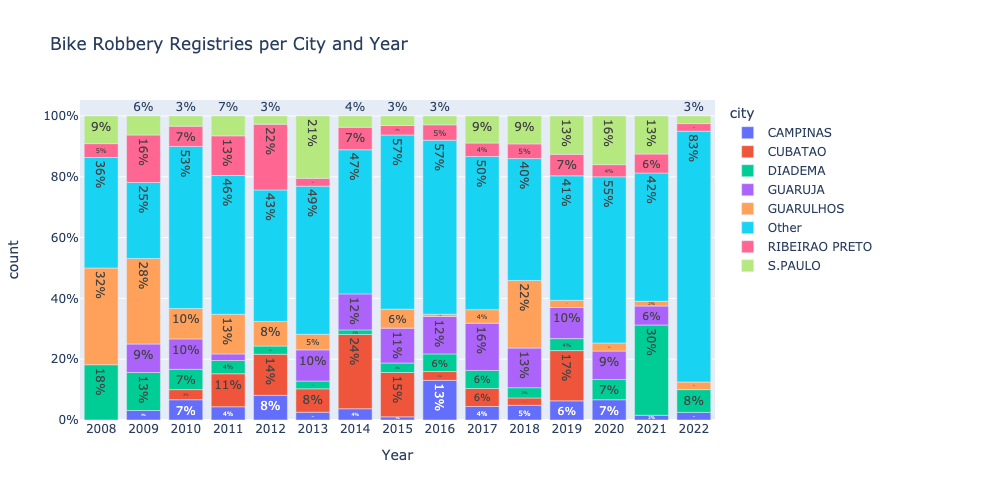

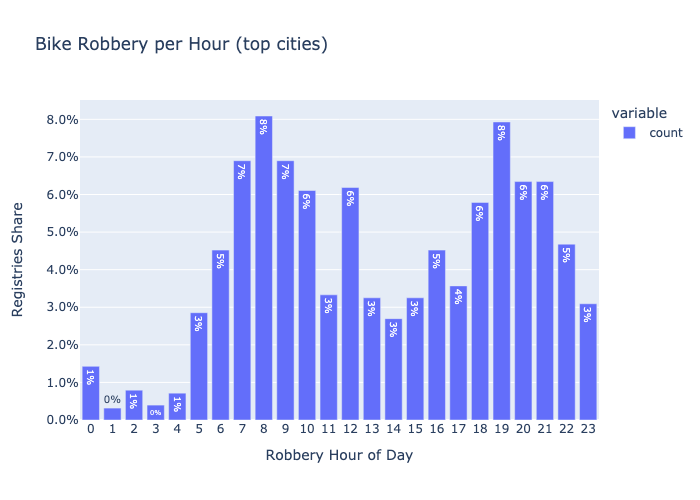

In [18]:
plot_robberies_per_year(df2, title='Bike Robbery Registries Per Year (Highways)')
plot_robberies_per_city(df2)
plot_registries_per_city_year(df2)
plot_registries_per_city_year_relative(df2)
plot_robbery_per_hour(df2)


In [19]:
replace_map = {
    'RODOVIA BANDEIRANTES': ['SP 348', 'BANDEIRANTES'],
    'RODOVIA ANHANGUERA': ['SP 330', 'ANHANGUERA'],
    'RODOVIA ANCHIETA': ['SP 150', 'ANCHIETA'],
    'RODOVIA IMIGRANTES': ['SP 160', 'IMIGRANTES'],
    'RODOVIA RODOANEL': ['RODOANEL'],
    'RODOVIA AYRTON SENNA': ['SP 070', 'AYRTON', 'AIRTON'],
    'RODOVIA DUTRA': ['BR 116', 'DUTRA'],
    'RODOVIA ADHEMAR DE BARROS': ['SP 342', 'ADHEMAR'],
    'RODOVIA DOMENICO RANGONI': ['248/055', 'RANGONI'],
    'RODOVIA MANUEL HIPOLITO REGO': ['SP 055', 'HIPOLITO REGO'],
    'RODOVIA ARIOVALDO': ['SP 061', 'ARIOVALDO'],
    'RODOVIA LAERCIO CORTE': ['SP 147', 'LAERCIO CORTE'],
    'RODOVIA SANTOS DUMONT': ['SP 075', 'SANTOS DUMONT'],
    'RODOVIA CORNELIO PIRES': ['SP 127', 'CORNELIO PIRES'],
    'RODOVIA CAMPINAS MONTE MOR': ['SP 101'],
    'RODOVIA FERNAO DIAS': ['BR 381', 'FERNAO', 'FERNÃO'],
    'RODOVIA ABRAAO ASSED': ['333']

}


df_mod = df.copy()

def f(input):
    if type(input) == str:
        for highway, patterns in replace_map.items():
            for pattern in patterns:
                if pattern in input:
                    return highway
        return input
    else:
        return input

df_mod['LOGRADOURO'] = df_mod.LOGRADOURO.map(f)

ind = df_mod.LOGRADOURO.str.contains('RODOVIA')
#ind &= df.LOGRADOURO.str.contains('BANDEIRANTES')
ind &= df_mod.DESCR_CONDUTA == 'TRANSEUNTE'
ind = ~pd.isnull(ind) & (ind == True)
df2_mod = df_mod.loc[ind]


print(df2_mod.LOGRADOURO.nunique())
df2_mod.LOGRADOURO.value_counts().head(10)

287


RODOVIA IMIGRANTES          243
RODOVIA AYRTON SENNA        231
RODOVIA ANCHIETA            187
RODOVIA SANTOS DUMONT       137
RODOVIA BANDEIRANTES        117
RODOVIA DUTRA               112
RODOVIA DOMENICO RANGONI    103
RODOVIA ANHANGUERA          102
RODOVIA RODOANEL             51
RODOVIA FERNAO DIAS          49
Name: LOGRADOURO, dtype: int64

<AxesSubplot:xlabel='ANO_BO'>

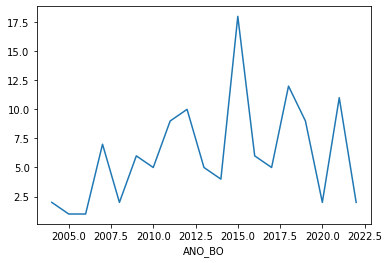

In [20]:
df2_mod.query('LOGRADOURO == "RODOVIA BANDEIRANTES"').groupby('ANO_BO').count().ID_DELEGACIA.plot()

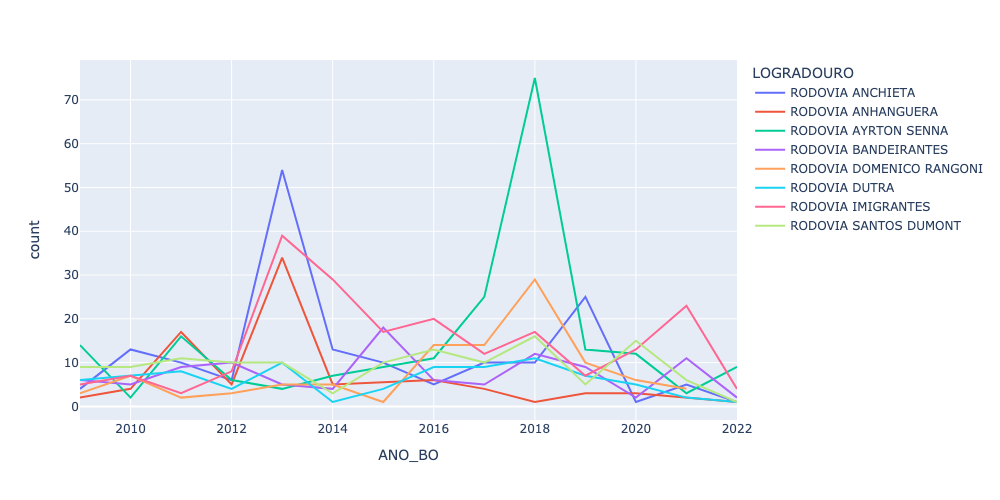

In [21]:
N = 8
top_highways = df2_mod.LOGRADOURO.value_counts().head(N).index

top_df2_mod = df2_mod[df2_mod.LOGRADOURO.map(lambda x: x in top_highways)]
y = top_df2_mod.groupby(['ANO_BO', 'LOGRADOURO']).count().ID_DELEGACIA
y.name = 'count'

fig_df = y.reset_index().query('ANO_BO > 2008')

fig = px.line(fig_df, 
              x='ANO_BO',
              y='count',
              color='LOGRADOURO',
              width=1000)
fig.show()

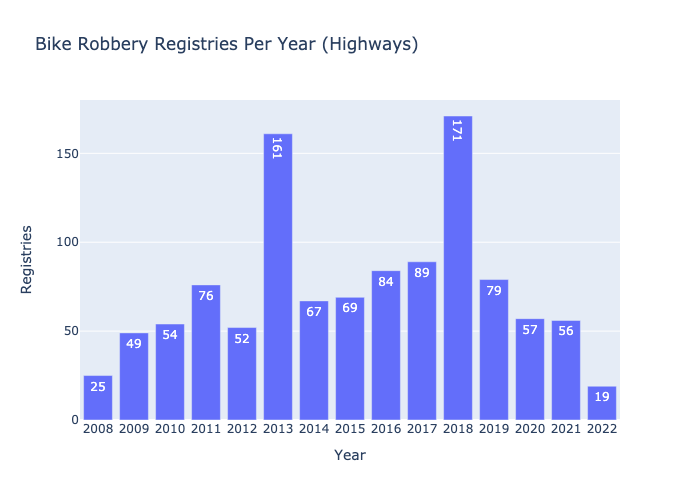

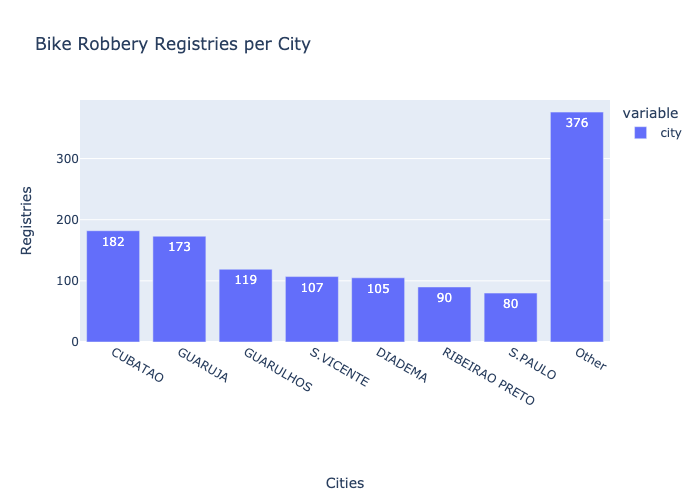

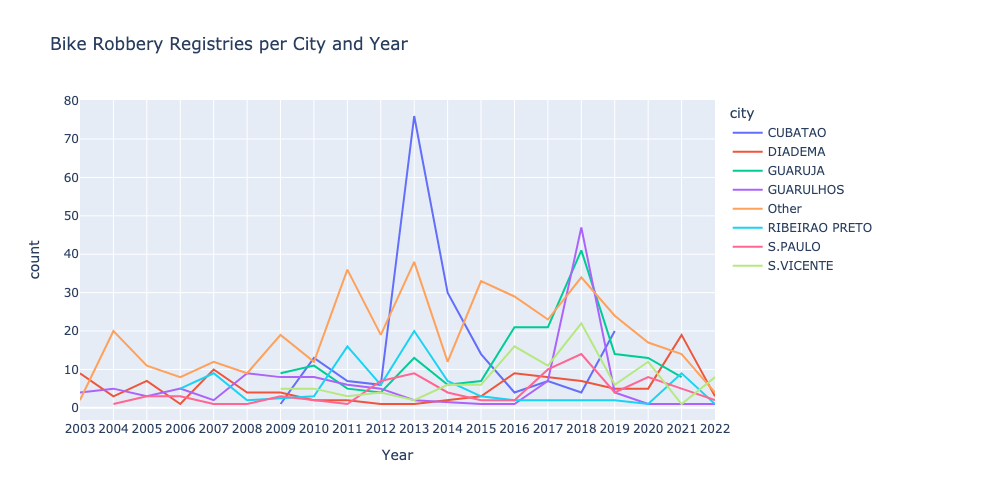

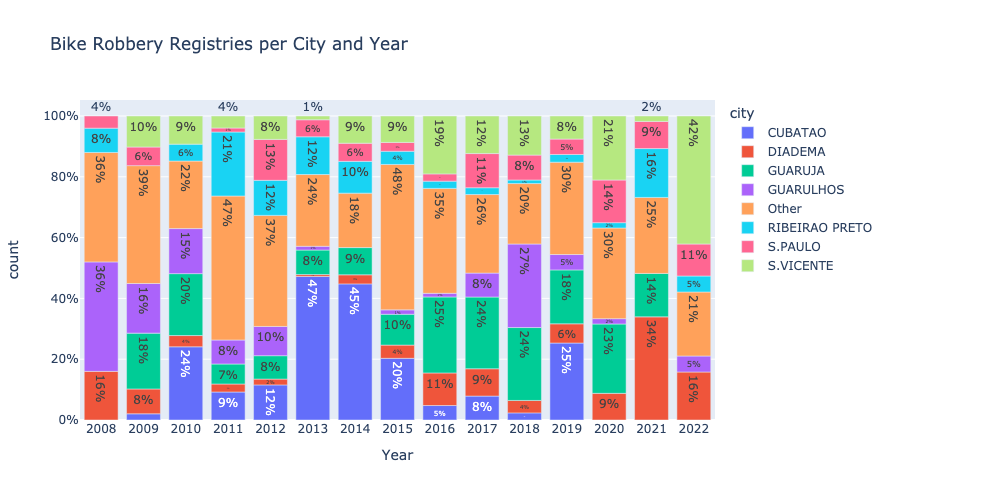

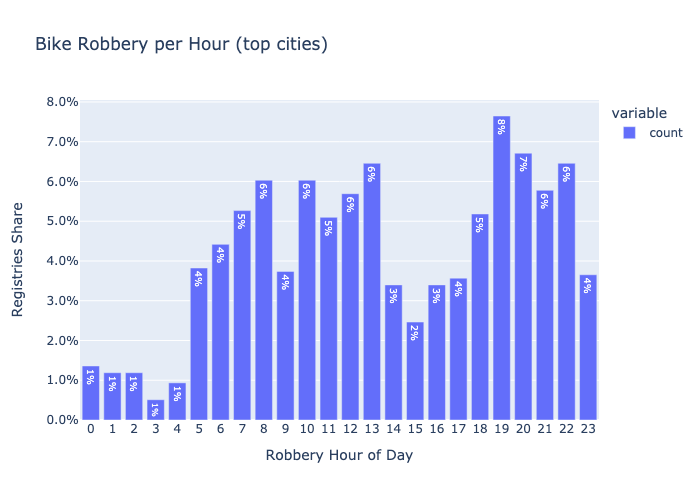

In [22]:
plot_robberies_per_year(top_df2_mod, title='Bike Robbery Registries Per Year (Highways)')
plot_robberies_per_city(top_df2_mod)
plot_registries_per_city_year(top_df2_mod)
plot_registries_per_city_year_relative(top_df2_mod)
plot_robbery_per_hour(top_df2_mod)